My goal is to predict changes in the federal funds rate using minutes from the federal open market committee

In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import time
import PyPDF2
import io
import re
import urllib.request
import pickle
import fitz
import os

from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split as tts
from nltk.corpus.reader.plaintext import CategorizedPlaintextCorpusReader
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier
#from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
import spacy

In [15]:
#functions for getting to the correct page to find the minutes
def minutesbutton(s):
    x = ('Minutes' in s.text and 
         'Executive' not in s.text 
         #'Historical Minutes' in s.text or 
         #'Minutes of Action' in s.text or 
         #'Minutes (Including' in s.text
        )
    return x
def findminuteslinks(soup):
    return [s['href'] for s in soup.find_all('a', class_='btn') if minutesbutton(s)]
def getsoup(link):
    r=requests.get(link)
    soup=BeautifulSoup(r.text)
    time.sleep(1)
    return soup
def correctlinks(linkfromhomepage):
    soup= getsoup(linkfromhomepage)
    minuteslinks=findminuteslinks(soup)
    if len(minuteslinks)>0:
        minuteslinks=['https://fraser.stlouisfed.org'+minuteslink for minuteslink in minuteslinks]
    return minuteslinks

def getpdflink(minuteslink):
    soup= getsoup(minuteslink)#'https://fraser.stlouisfed.org'+
    try:
        link_end= soup.find(text=re.compile('Download \(pdf\)')).parent['href']
        return 'https://fraser.stlouisfed.org'+link_end
    except:
        return None
def downloadpdf(pdflink):
    name=pdflink.split('/')[-1]
    r=requests.get(pdflink)
    time.sleep(1)
    file_destination_path='/Users/jamesmoss/Documents/GitHub/Notes and Exercises/IndividualExercises/Week15/FedMinutes/'
    with open(file_destination_path+'pdfs/'+name+'.pdf', 'wb') as f:
        f.write(r.content)
def getpdfs(originallink, minuteslinks):
    if len(minuteslinks)>0:
        for minuteslink in minuteslinks:
            pdflink=getpdflink(minuteslink)
            downloadpdf(pdflink)
    else:
        try:
            pdflink=getpdflink(originallink)
            downloadpdf(pdflink)
        except:
            pass
        
def listify(l):
    if isinstance(l, list):
        return l
    else:
        return [l]

def remove_names1993(doc):
    # Removes all text before "for immediate release", only works on docs after 1993
    deleteBefore= re.search("[Ff]or\s[Ii]mmediate\s[Rr]elease", \
                            doc).start() + len ('for immediate release')
    return doc[deleteBefore:]


## Loading the data

In [4]:
FOMC_url='https://fraser.stlouisfed.org/title/federal-open-market-committee-meeting-minutes-transcripts-documents-677?browse=1930s'

r=requests.get(FOMC_url)

In [5]:
soup=BeautifulSoup(r.text)

In [6]:
meetings=soup.find_all('a', class_='list-item')#[0]['href']

## Making a dataframe with relevant links and dates

In [3]:
decades=['1930s','1940s','1950s','1960s','1970s','1980s','1990s','2000s','2010s']
links=[]
dates=[]

for decade in decades:
    #get the soup info
    fomc_url='https://fraser.stlouisfed.org/title/federal-open-market-committee-meeting-minutes-transcripts-documents-677?browse='+decade
    r=requests.get(fomc_url)
    soup=BeautifulSoup(r.text)
    meetings=soup.find_all('a', class_='list-item')
    for meeting in meetings:
        link='https://fraser.stlouisfed.org'+meeting['href']
        date=meeting.span.text.strip()
        
        #go to the link
        #get the link that says minutes or historical minutes
        # can get it from the text here:?
        #class="btn btn-success btn-sm btn-sm btn-block goto-btn"
        links.append(link)
        dates.append(date)
    time.sleep(1)

In [4]:
minutes=pd.DataFrame(list(zip(dates, links)), columns =['type_date', 'links'])
minutes.head(5)

,type_date,links
0,"Meeting, July 20, 1933",https://fraser.stlouisfed.org/title/federal-op...
1,"Meeting, September 21, 1933",https://fraser.stlouisfed.org/title/federal-op...
2,"Meeting, October 10, 1933",https://fraser.stlouisfed.org/title/federal-op...
3,"Meeting, October 25, 1933",https://fraser.stlouisfed.org/title/federal-op...
4,"Meeting, March 5, 1934",https://fraser.stlouisfed.org/title/federal-op...


In [5]:
#todo: improve this later
def clean_date(date):
    date=date.replace('(Unscheduled)','')
    date=date.split(', ')
    date=[date[0], date[-1]].join(', ')
    return date

minutes['context']=minutes.type_date.str.split(pat=', ', n=1, expand=False).str[0]
minutes['date']=minutes.type_date.str.split(pat=', ', n=1, expand=False).str[1]
minutes['unscheduled']=minutes.type_date.str.contains('(Unscheduled)', regex=False)
minutes['date']=minutes.date.str.replace('(Unscheduled)','')
#the datestring is added onto the end of this
#https://fraser.stlouisfed.org/files/docs/historical/FOMC/meetingdocuments/

In [6]:
#minutes.type_date.str.contains('Meeting')
minutes.head(2)

,type_date,links,context,date,unscheduled
0,"Meeting, July 20, 1933",https://fraser.stlouisfed.org/title/federal-op...,Meeting,"July 20, 1933",False
1,"Meeting, September 21, 1933",https://fraser.stlouisfed.org/title/federal-op...,Meeting,"September 21, 1933",False


In [23]:
minutes2=minutes.dropna()
minutes2['minuteslinks']=minutes2['links'].apply(lambda x: correctlinks(x))

In [47]:
#minutes_copy=minutes2.copy()

In [96]:
minutes2=minutes_copy.copy()

In [98]:
#minutes2.loc[minutes2.minuteslinks.str.len()==0, 'minuteslinks']=[minutes2['links']]
minutes2['minuteslinks'][minutes2['minuteslinks'].str.len()==0]=minutes2['links']
minutes2['minuteslinks']=minutes2['minuteslinks'].apply(lambda x: listify(x))
minutes2['pdflinks']=minutes2['minuteslinks'].apply(lambda x: [getpdflink(link) for link in x])

/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Saving the DataFrame

In [120]:
minutes2.to_csv('/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone4/minuteslinks_dates.csv')
#Unnamed column was the index

In [123]:
minutes2.to_pickle('/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone4/minuteslinks_datesDF.pkl')

In [7]:
#minutes2=pd.read_csv('/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone4/minuteslinks_dates.csv')

In [12]:
minutes2=pickle.load(open('/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone4/minuteslinks_datesDF.pkl', 'rb'))

## Saving the PDFs

In [32]:
file_destination_path='/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone4/minutespdfs/'

for date in minutes2.pdflinks:
    for url in date:
        try:
            name=url.split('/')[-1]
            r=requests.get(url)
            time.sleep(1)

            with open(file_destination_path+name, 'wb') as f:
                f.write(r.content)
        except:
            continue

## Making the text files

In [52]:
# for document in file:
text_path='/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone4/minutestexts/'
pdf_path='/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone4/minutespdfs/'
pdf_list=os.listdir(pdf_path)
for document in pdf_list:
    textfile_name=document.split('.')[0]
    try:
        with fitz.open(pdf_path+document) as doc:
            text = ""
            for page in doc:
                text += page.getText()
            with open(text_path+textfile_name+'.txt', 'w') as textfile:
                textfile.write(text)
    except:
        print(document)

mupdf: cannot recognize version marker
mupdf: no objects found


.DS_Store


## Creating the corpus

In [13]:
text_path='/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone4/minutestexts/'
text_list=os.listdir(text_path)
def find_date(filename):
    datestring=re.findall('20\d\d\d\d\d\d|19\d\d\d\d\d\d|21\d\d\d\d\d\d', filename)
    return datestring
def text_from_filename(directory, filename):
    with open(directory+filename, 'r') as file:
        text = file.read()
    return text

In [21]:
minutes={}
minutes['date']=[]
minutes['filename']=[]
#minutes['text']=[]
count=0
for txtfile in text_list:
    if find_date(txtfile) and '.txt' in txtfile:
        count=count+1
        minutes['date'].append(find_date(txtfile)[0])
        minutes['filename'].append(txtfile)
print(count)

964


In [90]:
#Debugging
#I messed up my first time through and used the following code to correct my mistake, but it should be fixed above.
# def fix_date(doc_name):
#     try:
#         date=find_date(doc_name)[0]
#         return date
#     except:
#         print(doc_name)
#         return np.nan
# minutes_df['date']=minutes_df['filename'].apply(lambda x: fix_date(x))

900917ConfCall.txt
marconf.txt


In [22]:
minutes_df=pd.DataFrame.from_dict(minutes)
minutes_df.head(2)

,date,filename
0,20121023,fomchistmin19560417.txt
1,20121023,fomcminutes20090603.txt
2,20121023,fomcmoa19680206.txt
3,20121023,19971216min.txt
4,20121023,19851001MoA.txt


In [23]:
minutes_df['raw_text']=minutes_df['filename'].apply(lambda x: text_from_filename(text_path, x))

In [93]:
minutes_df.head(2)

,date,filename,raw_text,preprocessed,datetime,next_month
0,19560417,fomchistmin19560417.txt,A meeting of the Federal Open Market Committee...,meet feder open market committe held offic boa...,2012-10-23,2012-11-01
1,20090603,fomcminutes20090603.txt,Minutes of the Federal Open Market Committee \...,minut feder open market committe june 2009 joi...,2012-10-23,2012-11-01


## Preprocessing the text

In [345]:
#the first only takes away stop words and punctuation, the second also lemmatizes

def processing(doc, lemmatize=True):
    nlp = spacy.load('en')
    tokenized=nlp(doc)
    no_stops_punct=[token for token in tokenized if not token.is_stop if not token.is_punct if str(token).strip()]
    if lemmatize==True:
        no_stops_punct=[word.lemma_ for word in no_stops_punct]
    return no_stops_punct


def preprocess(doc):
    lemmatizer = WordNetLemmatizer()
    stemmer = SnowballStemmer('english')
    
    tokenized = word_tokenize(doc)

    cleaned = [stemmer.stem(lemmatizer.lemmatize(token.lower())) 
               for token in tokenized 
               if not token.lower() in stopwords.words('english') 
               if token.isalnum()] #should I make this also include numbers?
               

    untokenized = " ".join(cleaned)
    #preprocessed.append(untokenized)
        
    return untokenized


In [38]:
minutes_df['preprocessed']=minutes_df['raw_text'].apply(lambda x: preprocess(x))

In [346]:
minutes_df['no_stops_punct']=minutes_df['raw_text'].apply(lambda x: processing(x, lemmatize=False))

In [371]:
wordstoremove=['Mr.', 'Mrs.', 'Federal', 'Open', 'Market', 'Committee', 'members', 'Presidents', 
              'Chairman', 'meeting', 'a.m.', 'p.m.', 'held', 'minutes', 'governors', 'board', 'offices']
minutes_df['no_stops_punct_string']=minutes_df['no_stops_punct'].apply(lambda x: ' '.join([str(w) for w in x if str(w) not in wordstoremove]))



In [94]:
minutes_df['datetime']=pd.to_datetime(minutes_df['date'])
minutes_df['next_month']=minutes_df['datetime']+pd.offsets.MonthBegin(0)
minutes_df=minutes_df.dropna()
minutes_df.info()

In [100]:
minutes_df.to_pickle('/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone4/preprocessed_minutes_df.pkl')

## Getting the federal funds rate changes

In [43]:
fed_funds=pd.read_csv('/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone4/FEDFUNDS.csv')
fed_funds['datetime']=pd.to_datetime(fed_funds['DATE'])
fed_funds['shifted']=fed_funds['FEDFUNDS'].shift(1)
fed_funds['change']=fed_funds['FEDFUNDS']-fed_funds['shifted']
fed_funds['change_cat']=0
fed_funds.loc[fed_funds['change']>.125, 'change_cat']=1
fed_funds.loc[fed_funds['change']<-.125, 'change_cat']=-1
fed_funds['change_binary']=0
fed_funds.loc[fed_funds['change'].abs()>.125, 'change_binary']=1
fed_funds.head(3)

I added the change column, which indicates month over month change in the interest rate; change_cat, which indicates if there was negative (-1), no (0), or positive (1) change in the federal funds rate.

In [110]:
#when the dataframe starts
fed_funds.datetime.min()

Timestamp('1954-07-01 00:00:00')

Remember that the minutes_df dataset contains minutes from before 1954, which will be lost after merging

## Merging the data

In [315]:
merged_df=minutes_df.merge(fed_funds, how='inner', left_on='next_month', right_on='datetime', suffixes=['_min','_fed'])
merged_df=merged_df.drop(columns=['shifted'])
merged_df.tail(2)

In [404]:
merged_df.head(2)

,date,filename,raw_text,preprocessed,datetime_min,next_month,DATE,FEDFUNDS,datetime_fed,change,change_cat,change_binary,change_1,change_binary_1
0,19560417,fomchistmin19560417.txt,A meeting of the Federal Open Market Committee...,meet feder open market committe held offic boa...,1956-04-17,1956-05-01,1956-05-01,2.75,1956-05-01,0.13,1,1,-0.05,0
1,20090603,fomcminutes20090603.txt,Minutes of the Federal Open Market Committee \...,minut feder open market committe june 2009 joi...,2009-06-03,2009-07-01,2009-07-01,0.16,2009-07-01,-0.05,0,0,-0.05,0


In [318]:
#Shifting the changes down one for the purposes of trying to predict an extra month in the future:
merged_df['change_1']=merged_df['change'].shift(-1).dropna()
merged_df['change_binary_1']=merged_df['change_binary'].shift(-1)
merged_df=merged_df.dropna()
merged_df['change_binary_1']=merged_df['change_binary_1'].astype(int)

In [8]:
#merged_df.to_pickle('/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone4/merged_df.pkl')
merged_df.to_csv('/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone4/merged_df.csv', index=False)

#merged_df=pickle.load(open('/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone4/merged_df.pkl', 'rb'))

In [18]:
#make a column of tokenized documents 
nlp = spacy.load('en')
nlp.add_pipe(nlp.create_pipe('sentencizer'))
merged_df['tokenized']=merged_df['raw_text'].apply(lambda x: nlp(x))

In [ ]:
merged_df=merged_df.drop(columns=['tokenized'])

## EDA

Examining federal funds rate changes:

In [389]:
fed_funds.datetime.shape

(796,)

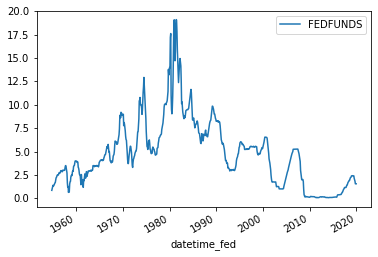

In [319]:
merged_df.plot(y='FEDFUNDS',x='datetime_fed')

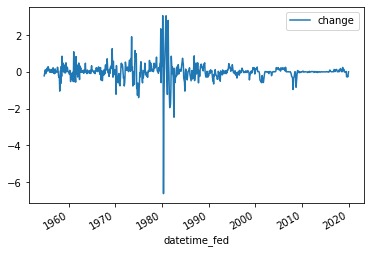

In [320]:
merged_df.plot(y='change',x='datetime_fed')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8756704d0>]],
      dtype=object)

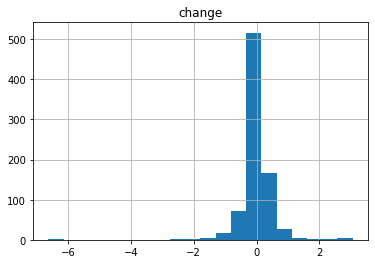

In [338]:
merged_df.hist('change', bins=20)

Now, looking at the minutes

In [ ]:
minutes_summary_df=minutes_df[['no_stops_punct_string','datetime']].copy()
minutes_summary_df['year']=minutes_summary_df['datetime'].dt.year
minutes_summary_df['decade']=minutes_summary_df['datetime'].dt.year//10
yearly_text=minutes_df[['raw_text', 'datetime']]

In [ ]:
#was trying to make a wordcloud per decade, should probably give up
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

for decadetext in minutes_summary_df[['no_stops_punct_string','decade']].groupby(by='decade')['no_stops_punct_string'].transform(lambda x: ' '.join(x)):
    wordcloud = WordCloud(max_font_size=70, max_words=100, background_color="white").generate(decadetext)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

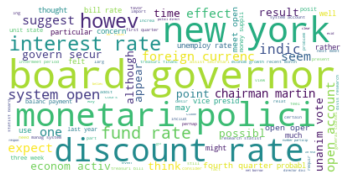

In [392]:
#making a word cloud for all the text
remove_words=['feder', 'reserv', 'per cent', 'market', 'committe', 'reserve', 'bank']
all_text=' '.join(minutes_df['preprocessed'])
for word in remove_words:
    all_text=all_text.replace(word, '')
wordcloud = WordCloud(max_font_size=70, max_words=100, background_color="white").generate(all_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [398]:
minutes_df['length']=minutes_df['preprocessed'].apply(lambda x: len(x))
minutes_df['vocab']=minutes_df['preprocessed'].apply(lambda x: len(set(x)))

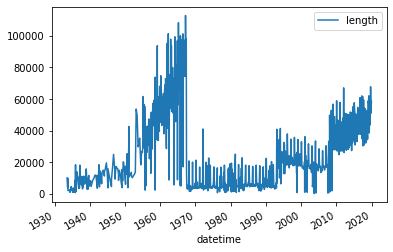

In [399]:
minutes_df.plot(y='length',x='datetime')

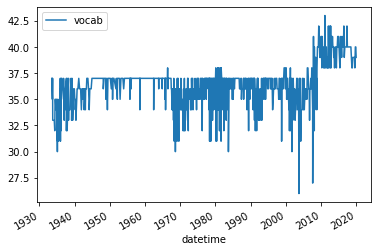

In [402]:
minutes_df.plot(y='vocab',x='datetime')

In [397]:
#get preprocessed summary statistics
minutes_df.head(2)

,date,filename,raw_text,preprocessed,datetime,next_month,no_stops_punct,no_stops_punct_string
0,19560417,fomchistmin19560417.txt,A meeting of the Federal Open Market Committee...,meet feder open market committe held offic boa...,1956-04-17,1956-05-01,"[meeting, Federal, Open, Market, Committee, he...",Board Governors Reserve System Washington Tues...
1,20090603,fomcminutes20090603.txt,Minutes of the Federal Open Market Committee \...,minut feder open market committe june 2009 joi...,2009-06-03,2009-07-01,"[Minutes, Federal, Open, Market, Committee, Ju...",Minutes June 23 24 2009 joint Commit- tee Boar...


In [ ]:
#todo: find keywords from each decade
#Extracting keywords
from gensim.summarization import keywords
def keywords(docs):
    for index, doc in enumerate(docs):
        key_words = keywords(doc, words=5, lemmatize=True).split('\n')
        print('Article', index, 'Keywords:', key_words)

## Making the classifiers

### Binary Classification:

#### Using all available dates (back to 1954):

In [321]:
#random forest
x_train, x_test, y_train, y_test = tts(merged_df['preprocessed'], merged_df['change_binary'], test_size=0.3)

rfc_model = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_estimators=75, min_samples_leaf=4, max_depth=12)),
])

rfc_model.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=12, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                  

In [322]:
rfc_model.score(x_train, y_train)

0.9634782608695652

In [323]:
rfc_model_predictions = rfc_model.predict(x_test)
print(classification_report(y_test, rfc_model_predictions))

              precision    recall  f1-score   support

           0       0.68      0.76      0.72       116
           1       0.76      0.69      0.72       131

    accuracy                           0.72       247
   macro avg       0.72      0.72      0.72       247
weighted avg       0.72      0.72      0.72       247



In [253]:
#logistic regression
log_model = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('scl', StandardScaler(with_mean=False)),
    ('log', LogisticRegression()),
])

log_model.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                                  sublinear_tf=False, use_idf=True)),
                ('scl',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('log',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_s

In [254]:
log_model_predictions = log_model.predict(x_test)
print(classification_report(y_test, log_model_predictions))

              precision    recall  f1-score   support

           0       0.73      0.66      0.69       136
           1       0.63      0.71      0.67       112

    accuracy                           0.68       248
   macro avg       0.68      0.68      0.68       248
weighted avg       0.69      0.68      0.68       248



In [229]:
# AdaBoost
ada_model = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('log', AdaBoostClassifier()),
])
ada_model.fit(x_train, y_train)
ada_model.score(x_train, y_train)

0.9410745233968805

In [230]:
ada_model_predictions = ada_model.predict(x_test)
print(classification_report(y_test, ada_model_predictions))

              precision    recall  f1-score   support

           0       0.68      0.73      0.71       127
           1       0.70      0.64      0.67       121

    accuracy                           0.69       248
   macro avg       0.69      0.69      0.69       248
weighted avg       0.69      0.69      0.69       248



***(You can see that you don't get amazing results for the entire dataset (all years). Your predictions are going to be right 70-75% of the time)***

#### Post 1993 documents:

1993 is when the modern minutes of the FOMC developed, and they began to become more transparent about planning with the public. You can see that the predictive power of the model greatly improves

In [ ]:
merged_1993_df=merged_df[merged_df['datetime_min'] > '1993-01-01']
#merged_1993_df.sort_values(by=['datetime_min']).head(3)

In [403]:
merged_1993_df.change_binary_1.value_counts()
merged_1993_df.head(2)

,date,filename,raw_text,preprocessed,datetime_min,next_month,DATE,FEDFUNDS,datetime_fed,change,change_cat,change_binary,change_1,change_binary_1
1,20090603,fomcminutes20090603.txt,Minutes of the Federal Open Market Committee \...,minut feder open market committe june 2009 joi...,2009-06-03,2009-07-01,2009-07-01,0.16,2009-07-01,-0.05,0,0,-0.05,0
2,20090624,fomcminutes20090624.txt,Minutes of the Federal Open Market Committee \...,minut feder open market committe june 2009 joi...,2009-06-24,2009-07-01,2009-07-01,0.16,2009-07-01,-0.05,0,0,0.34,1


In [327]:
x_train1993, x_test1993, y_train1993, y_test1993 = tts(merged_1993_df['preprocessed'], merged_1993_df['change_binary'], test_size=0.3)

rfc_model = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_estimators=75, min_samples_leaf=4, max_depth=12)),
])

rfc_model.fit(x_train1993, y_train1993)
rfc_model_predictions = model.predict(x_test1993)
print(classification_report(y_test1993, rfc_model_predictions))


              precision    recall  f1-score   support

           0       0.93      0.97      0.95        58
           1       0.89      0.80      0.84        20

    accuracy                           0.92        78
   macro avg       0.91      0.88      0.90        78
weighted avg       0.92      0.92      0.92        78



In [330]:
#why is this so low?
score=cross_val_score(rfc_model, merged_1993_df['preprocessed'], merged_1993_df['change_binary'], cv=10, scoring='f1_macro')
print(score, score.mean())

[0.66408269 0.62857143 0.52971576 0.55681818 0.38095238 0.62857143
 0.52971576 0.52971576 0.4047619  0.70862471] 0.556153000746024


***Now looking one period into the future:***

In [312]:
x_train1993, x_test1993, y_train1993, y_test1993 = tts(merged_1993_df['preprocessed'], merged_1993_df['change_binary_1'], test_size=0.3)

rfc_model = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_estimators=150, min_samples_leaf=12, max_depth=12)),
])

rfc_model.fit(x_train1993, y_train1993)
rfc_model_predictions = model.predict(x_test1993)
print(rfc_model.score(x_train1993,y_train1993))
print(classification_report(y_test1993, rfc_model_predictions))

0.9166666666666666
              precision    recall  f1-score   support

           0       0.67      0.88      0.76        48
           1       0.60      0.30      0.40        30

    accuracy                           0.65        78
   macro avg       0.63      0.59      0.58        78
weighted avg       0.64      0.65      0.62        78



Trying to predict the rate changes one month out is more difficult. For comparison, FFR futures have about a 75% accuracy rate

**Trying regression, rather than classification:**

In [282]:
x_train1993, x_test1993, y_train1993, y_test1993 = tts(merged_1993_df['preprocessed'], merged_1993_df['change'], test_size=0.3)

rfc_model = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestRegressor(n_estimators=200, min_samples_leaf=10, max_depth=12)),
])

rfc_model.fit(x_train1993, y_train1993)
#rfc_model_predictions = model.predict(x_test1993)
print(rfc_model.score(x_train1993, y_train1993))
print(rfc_model.score(x_test1993, y_test1993))


0.603802449384434
0.47472169127071673


In [332]:
#category balance, it's a bit unbalanced:
merged_1993_df['change_cat'].value_counts()

 0    184
-1     39
 1     35
Name: change_cat, dtype: int64

#### Now trying to predict multiple classes:


In [331]:
#not sure why I couldn't get this to work
x_train1993, x_test1993, y_train1993, y_test1993 = tts(merged_1993_df['preprocessed'], merged_1993_df['change_cat'], test_size=0.3)

rfc_model = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_estimators=75, min_samples_leaf=4, max_depth=12)),
])

rfc_model.fit(x_train1993, y_train1993)
rfc_model_predictions = model.predict(x_test1993)
print(classification_report(y_test1993, rfc_model_predictions))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        16
           0       0.85      0.98      0.91        47
           1       0.50      0.80      0.62        15

    accuracy                           0.74        78
   macro avg       0.45      0.59      0.51        78
weighted avg       0.61      0.74      0.67        78



/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [334]:
print(np.unique(rfc_model_predictions, return_counts=True))

(array([0, 1]), array([54, 24]))


## Future Work:

***Trying a LSTM to incorperate the time series aspects of the data***

***Integrate other leading economic variables into analysis***

In [9]:
# First, embed the text using GloVe, with pretrained vectors
embeddings_dict = {}
with open("/Users/jamesmoss/Downloads/glove.6B/glove.6B.50d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [1]:
# adoc=[s.string.strip() for s in  merged_df.tokenized[0].sents]
# [s for s in adoc if str(s).strip()]
# merged_df.tokenized[0]

In [ ]:
#TODO: representing the documents with a CNN

model=Sequential()

#first hidden layer
model.add(Conv2D(32,(3,3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#the above are part of the same layer
#stride is 1 by default


Also planning on using BERT to embed the sentences, use a CNN to embed the documents, then a RNN for the classification

In [ ]:
# for future reference:
#list of minutes link (1993 onward):
# https://www.fedsearch.org/fomc-docs/search?advanced_search=true&fomc_document_type=minutes&text=&search_precision=All+Words&from_month=3&from_year=1936&to_month=12&to_year=2020&sort=Most+Recent+First&Search=Search
#get futures data from the table here:
#https://www.quandl.com/data/CHRIS/CME_FF1-30-Day-Federal-Funds-Futures-Continuous-Contract-1-FF1-Front-Month